<h3>Подключение необходимых библиотек и модулей</h3>

In [ ]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from statsmodels.stats.multitest import multipletests
from transformers import pipeline

from evaluation import evaluate_classification, plot_confusion_matrix
from processing import text_preprocessing

In [2]:
df = pd.read_parquet("train-00000-of-00001.parquet")
df

,title,text,topic,labels
0,"Два немца стали кандидатами в тренеры ""Динамо""",Два немецких футбольных тренера стали кандидат...,Спорт,1
1,Россия добавит тяги китайским истребителям,"Российские турбореактивные двигатели РД-93, пр...",Наука и техника,2
2,«Газпром» пересмотрел планы по строительству «...,«Газпром» сократил протяженность участка газоп...,Бизнес,4
3,"Российские зрители не услышат, как поет Ричард...",\nНа экраны российских кинотеатров выходит оди...,Культура,3
4,Призовой фонд Australian Open-2013 достиг реко...,Организаторы Открытого чемпионата Австралии по...,Спорт,1
...,...,...,...,...
185967,Суд отказался рассматривать иск по тарифам МПС,Арбитражный суд Москвы не принял к рассмотрени...,Экономика,0
185968,Мнение Михалкова о Ельцин-центре испортилось п...,"Режиссер Никита Михалков выразил сожаление, чт...",Культура,3
185969,"Российские страховщики увеличили активы до 1,6...",Активы российских страховщиков в 2015 году выр...,Экономика,0
185970,Украина введет ответное продэмбарго против России,"Премьер-министр Украины Арсений Яценюк заявил,...",Экономика,0


In [3]:
df = df.drop_duplicates()
df = df.drop(columns=["labels"])
df

,title,text,topic,title_preprocessed
0,"Два немца стали кандидатами в тренеры ""Динамо""",Два немецких футбольных тренера стали кандидат...,Спорт,немец стать кандидат тренер динамо
1,Россия добавит тяги китайским истребителям,"Российские турбореактивные двигатели РД-93, пр...",Наука и техника,россия добавить тяга китайский истребитель
2,«Газпром» пересмотрел планы по строительству «...,«Газпром» сократил протяженность участка газоп...,Бизнес,газпром пересмотреть план строительство сила с...
3,"Российские зрители не услышат, как поет Ричард...",\nНа экраны российских кинотеатров выходит оди...,Культура,российский зритель услышать петь ричард гир
4,Призовой фонд Australian Open-2013 достиг реко...,Организаторы Открытого чемпионата Австралии по...,Спорт,призовой фонд australian open достигнуть рекор...
...,...,...,...,...
185967,Суд отказался рассматривать иск по тарифам МПС,Арбитражный суд Москвы не принял к рассмотрени...,Экономика,суд отказаться рассматривать иск тариф мпс
185968,Мнение Михалкова о Ельцин-центре испортилось п...,"Режиссер Никита Михалков выразил сожаление, чт...",Культура,мнение михалков ельцин центр испортиться посещ...
185969,"Российские страховщики увеличили активы до 1,6...",Активы российских страховщиков в 2015 году выр...,Экономика,российский страховщик увеличить актив триллион...
185970,Украина введет ответное продэмбарго против России,"Премьер-министр Украины Арсений Яценюк заявил,...",Экономика,украина ввести ответный продэмбарго против россия


In [4]:
X = df["title_preprocessed"]
y = df["topic"].astype("category")
X

0                        немец стать кандидат тренер динамо
1                россия добавить тяга китайский истребитель
2         газпром пересмотреть план строительство сила с...
3               российский зритель услышать петь ричард гир
4         призовой фонд australian open достигнуть рекор...
                                ...                        
185967           суд отказаться рассматривать иск тариф мпс
185968    мнение михалков ельцин центр испортиться посещ...
185969    российский страховщик увеличить актив триллион...
185970    украина ввести ответный продэмбарго против россия
185971          путин увидеть биткоина потенциальный угроза
Name: title_preprocessed, Length: 185954, dtype: object

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, stratify=y, shuffle=True, test_size=0.2, random_state=1
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    stratify=y_temp,
    shuffle=True,
    test_size=0.5,
    random_state=1,
)

<h3>Мешок слов на униграммах, биграммах, триграммах + отбор токенов</h3>

In [7]:
vectorizer = CountVectorizer(
    lowercase=False,
    token_pattern=None,
    tokenizer=lambda token: word_tokenize(token, language="russian"),
    dtype=np.float32,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.85,
)
vectorizer

,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",False
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",<function <la...001DF77D6B880>
,"stop_words stop_words: {'english'}, list, default=NoneIf 'english', a built-in stop word list for English is used.There are several known issues with 'english' and you shouldconsider an alternative (see :ref:`stop_words`).If a list, that list is assumed to contain stop words, all of whichwill be removed from the resulting tokens.Only applies if ``analyzer == 'word'``.If None, no stop words will be used. In this case, setting `max_df`to a higher value, such as in the range (0.7, 1.0), can automatically detectand filter stop words based on intra corpus document frequency of terms.",None
,"token_pattern token_pattern: str or None, default=r""(?u)\\b\\w\\w+\\b""Regular expression denoting what constitutes a ""token"", only usedif ``analyzer == 'word'``. The default regexp select tokens of 2or more alphanumeric characters (punctuation is completely ignoredand always treated as a token separator).If there is a capturing group in token_pattern then thecaptured group content, not the entire match, becomes the token.At most one capturing group is permitted.",None
,"ngram_range ngram_range: tuple (min_n, max_n), default=(1, 1)The lower and upper boundary of the range of n-values for differentword n-grams or char n-grams to be extracted. All values of n suchsuch that min_n <= n <= max_n will be used. For example an``ngram_range`` of ``(1, 1)`` means only unigrams, ``(1, 2)`` meansunigrams and bigrams, and ``(2, 2)`` means only bigrams.Only applies if ``analyzer`` is not callable.","(1, ...)"
,"analyzer analyzer: {'word', 'char', 'char_wb'} or callable, default='word'Whether the feature should be made of word n-gram or charactern-grams.Option 'char_wb' creates character n-grams only from text insideword boundaries; n-grams at the edges of words are padded with space.If a callable is passed it is used to extract the sequence of featuresout of the raw, unprocessed input... versionchanged:: 0.21Since v0.21, if ``input`` is ``filename`` or ``file``, the data isfirst read from the file and then passed to the given callableanalyzer.",'word'


In [8]:
X_train_new = vectorizer.fit_transform(X_train)
X_val_new = vectorizer.transform(X_val)
X_train_new

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1186363 stored elements and shape (148763, 38819)>

In [8]:
token_importances = pd.DataFrame(
    {
        "token": vectorizer.get_feature_names_out(),
        "chi2_statistics": chi2(X_train_new, y_train)[0],
        "p_value": chi2(X_train_new, y_train)[1],
    }
)
token_importances.sort_values(by="chi2_statistics", ascending=False)

,token,chi2_statistics,p_value
29854,сборная,13261.348663,0.000000
15955,матч,11288.493445,0.000000
35960,фильм,8518.129747,0.000000
37516,чемпионат,6559.542474,0.000000
3518,банк,6515.889161,0.000000
...,...,...,...
13050,картофельный,0.333724,0.987534
19968,объяснять,0.333724,0.987534
31662,сообща,0.333724,0.987534
8845,двадцатый,0.333724,0.987534


In [9]:
reject_fdr, pvals_corrected_fdr, _, _ = multipletests(
    token_importances["p_value"], alpha=0.05, method="fdr_bh"
)
X_train_filtered = X_train_new[:, reject_fdr]
X_val_filtered = X_val_new[:, reject_fdr]
X_train_filtered

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1125523 stored elements and shape (148763, 32601)>

<h3>Для отбора признаков используется <a href="https://ru.wikipedia.org/wiki/Критерий_согласия_Пирсона">критерий согласия хи-квадрат Пирсона</a> с поправкой <a href="http://www.machinelearning.ru/wiki/index.php?title=Метод_Бенджамини-Хохберга">Бенджамини-Хохберга</a>.<br>Отфильтровывались те токены, у которых скорректированный p-value был больше 0.05.</h3>

In [10]:
token_importances_filtered = token_importances.sort_values(
    by="chi2_statistics", ascending=False
)[: X_train_filtered.shape[1]]
token_importances_filtered

,token,chi2_statistics,p_value
29854,сборная,13261.348663,0.000000
15955,матч,11288.493445,0.000000
35960,фильм,8518.129747,0.000000
37516,чемпионат,6559.542474,0.000000
3518,банк,6515.889161,0.000000
...,...,...,...
37408,чаша,9.915679,0.041872
12100,изуродовать,9.915679,0.041872
17758,назвать обладатель,9.915679,0.041872
11439,захоронить,9.915679,0.041872


In [11]:
top_50_token = token_importances_filtered.iloc[:30]

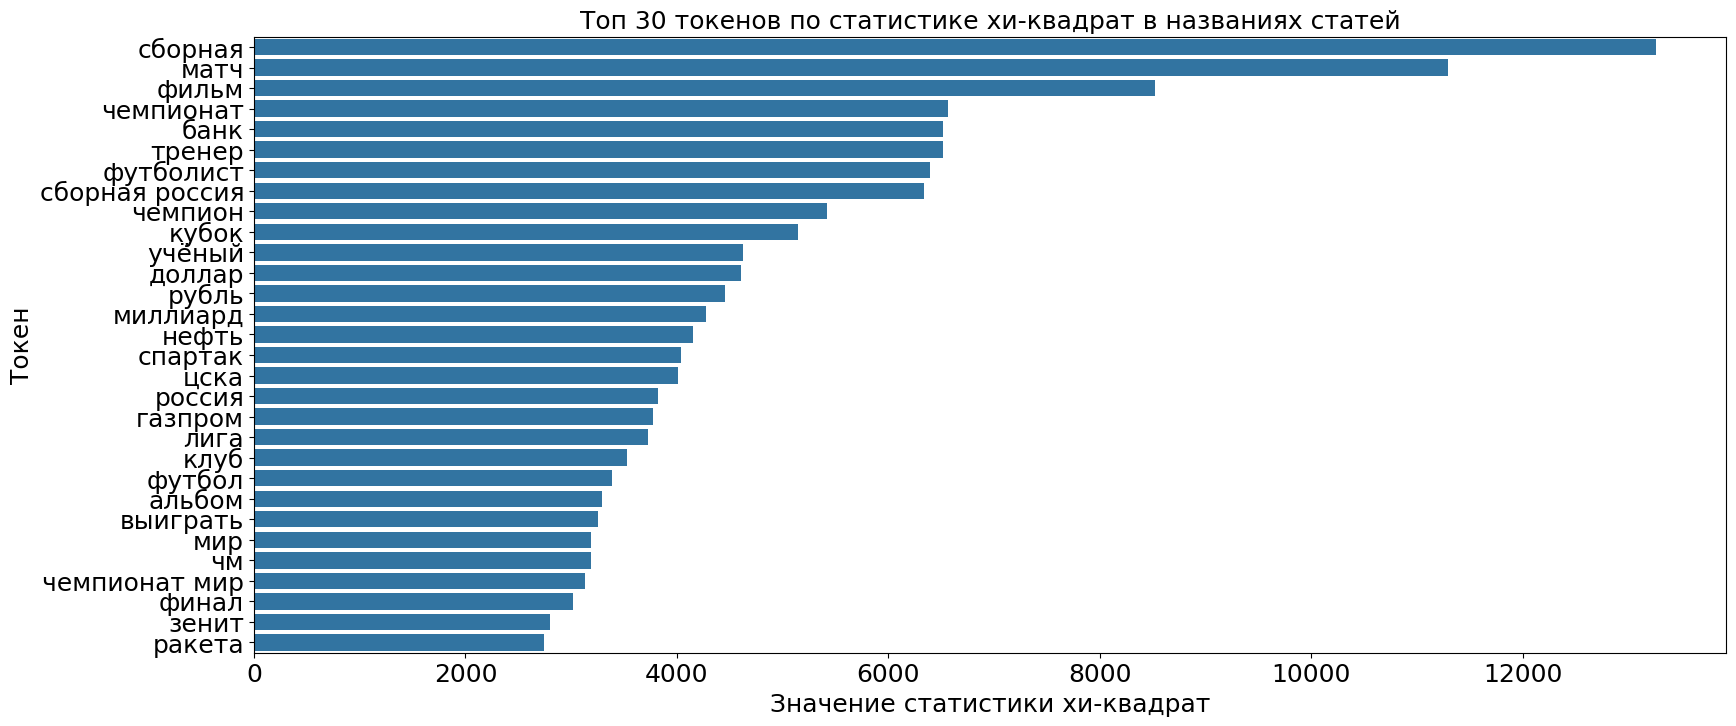

In [ ]:
font_size = 18
plt.figure(figsize=(19, 8))
plt.title(
    "Топ 30 токенов по статистике хи-квадрат в названиях статей", fontsize=font_size
)
sns.barplot(top_50_token, y="token", x="chi2_statistics", n_boot=0, orient="h")
plt.xlabel("Значение статистики хи-квадрат", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.ylabel("Токен", fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()

<h3>Наиболее значимыми токенами являются спортивные - по ним однозначно можно определить категорию Спорт.</h3>

In [13]:
nb = ComplementNB().fit(X_train_filtered, y_train)
nb

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueOnly used in edge case with a single class in the training set.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. Not used.",None
,"norm norm: bool, default=FalseWhether or not a second normalization of the weights is performed. Thedefault behavior mirrors the implementations found in Mahout and Weka,which do not follow the full algorithm described in Table 9 of thepaper.",False


In [14]:
y_pred_train = nb.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.783     0.148     0.249      4275
       Культура      0.935     0.958     0.946     31038
Наука и техника      0.932     0.917     0.925     30520
          Спорт      0.974     0.983     0.978     37144
      Экономика      0.897     0.953     0.925     45786

       accuracy                          0.931    148763
      macro avg      0.904     0.792     0.805    148763
   weighted avg      0.928     0.931     0.923    148763

MCC равен 0.909


In [15]:
y_pred_val = nb.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.667     0.101     0.176       534
       Культура      0.929     0.948     0.938      3880
Наука и техника      0.919     0.906     0.913      3815
          Спорт      0.966     0.979     0.972      4643
      Экономика      0.887     0.944     0.914      5723

       accuracy                          0.921     18595
      macro avg      0.874     0.776     0.783     18595
   weighted avg      0.916     0.921     0.912     18595

MCC равен 0.896


In [16]:
log_reg = LogisticRegression(class_weight="balanced", random_state=1, max_iter=200).fit(
    X_train_filtered, y_train
)
log_reg

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",1
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

In [17]:
y_pred_train = log_reg.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.551     0.986     0.707      4275
       Культура      0.968     0.978     0.973     31038
Наука и техника      0.958     0.964     0.961     30520
          Спорт      0.993     0.989     0.991     37144
      Экономика      0.982     0.902     0.941     45786

       accuracy                          0.955    148763
      macro avg      0.891     0.964     0.915    148763
   weighted avg      0.965     0.955     0.958    148763

MCC равен 0.942


In [18]:
y_pred_val = log_reg.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.327     0.579     0.418       534
       Культура      0.932     0.942     0.937      3880
Наука и техника      0.911     0.923     0.917      3815
          Спорт      0.984     0.968     0.976      4643
      Экономика      0.925     0.857     0.890      5723

       accuracy                          0.908     18595
      macro avg      0.816     0.854     0.828     18595
   weighted avg      0.921     0.908     0.913     18595

MCC равен 0.880


In [19]:
lgbm = LGBMClassifier(class_weight="balanced", random_state=1).fit(
    X_train_filtered, y_train
)
lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.427468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17980
[LightGBM] [Info] Number of data points in the train set: 148763, number of used features: 8823
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [20]:
y_pred_train = lgbm.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.252     0.808     0.384      4275
       Культура      0.833     0.892     0.861     31038
Наука и техника      0.871     0.859     0.865     30520
          Спорт      0.978     0.927     0.952     37144
      Экономика      0.924     0.737     0.820     45786

       accuracy                          0.844    148763
      macro avg      0.772     0.845     0.777    148763
   weighted avg      0.888     0.844     0.858    148763

MCC равен 0.803


In [21]:
y_pred_val = lgbm.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.213     0.678     0.324       534
       Культура      0.825     0.885     0.854      3880
Наука и техника      0.858     0.846     0.852      3815
          Спорт      0.977     0.921     0.948      4643
      Экономика      0.905     0.728     0.807      5723

       accuracy                          0.832     18595
      macro avg      0.756     0.811     0.757     18595
   weighted avg      0.877     0.832     0.847     18595

MCC равен 0.787


<h3>Лучшие метрики на BoW факторах у модели Complement Naive Bayes.<br>Это улучшенный вариант MultinomialNB, подходящий для несбалансированных наборов данных.</h3>

<h3>TF-IDF на униграммах, биграммах, триграммах + отбор токенов</h3>

In [22]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    token_pattern=None,
    tokenizer=lambda token: word_tokenize(token, language="russian"),
    dtype=np.float32,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.85,
)
vectorizer

,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",False
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",<function <la...0015E63875940>
,"analyzer analyzer: {'word', 'char', 'char_wb'} or callable, default='word'Whether the feature should be made of word or character n-grams.Option 'char_wb' creates character n-grams only from text insideword boundaries; n-grams at the edges of words are padded with space.If a callable is passed it is used to extract the sequence of featuresout of the raw, unprocessed input... versionchanged:: 0.21 Since v0.21, if ``input`` is ``'filename'`` or ``'file'``, the data is first read from the file and then passed to the given callable analyzer.",'word'
,"stop_words stop_words: {'english'}, list, default=NoneIf a string, it is passed to _check_stop_list and the appropriate stoplist is returned. 'english' is currently the only supported stringvalue.There are several known issues with 'english' and you shouldconsider an alternative (see :ref:`stop_words`).If a list, that list is assumed to contain stop words, all of whichwill be removed from the resulting tokens.Only applies if ``analyzer == 'word'``.If None, no stop words will be used. In this case, setting `max_df`to a higher value, such as in the range (0.7, 1.0), can automatically detectand filter stop words based on intra corpus document frequency of terms.",None
,"token_pattern token_pattern: str, default=r""(?u)\\b\\w\\w+\\b""Regular expression denoting what constitutes a ""token"", only usedif ``analyzer == 'word'``. The default regexp selects tokens of 2or more alphanumeric characters (punctuation is completely ignoredand always treated as a token separator).If there is a capturing group in token_pattern then thecaptured group content, not the entire match, becomes the token.At most one capturing group is permitted.",None
,"ngram_range ngram_range: tuple (min_n, max_n), default=(1, 1)The lower and upper boundary of the range of n-values for differentn-grams to be extracted. All values of n such that min_n <= n <= max_nwill be used. For example an ``ngram_range`` of ``(1, 1)`` means onlyunigrams, ``(1, 2)`` means unigrams and bigrams, and ``(2, 2)`` meansonly bigrams.Only applies if ``analyzer`` is not ca

In [23]:
X_train_new = vectorizer.fit_transform(X_train)
X_val_new = vectorizer.transform(X_val)
X_train_new

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1186363 stored elements and shape (148763, 38819)>

In [24]:
X_train_filtered = X_train_new[:, reject_fdr]
X_val_filtered = X_val_new[:, reject_fdr]
X_train_filtered

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1125523 stored elements and shape (148763, 32601)>

In [25]:
nb2 = ComplementNB().fit(X_train_filtered, y_train)
nb2

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueOnly used in edge case with a single class in the training set.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. Not used.",None
,"norm norm: bool, default=FalseWhether or not a second normalization of the weights is performed. Thedefault behavior mirrors the implementations found in Mahout and Weka,which do not follow the full algorithm described in Table 9 of thepaper.",False


In [26]:
y_pred_train = nb2.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.792     0.162     0.269      4275
       Культура      0.937     0.959     0.948     31038
Наука и техника      0.934     0.920     0.927     30520
          Спорт      0.975     0.983     0.979     37144
      Экономика      0.900     0.955     0.927     45786

       accuracy                          0.933    148763
      macro avg      0.908     0.796     0.810    148763
   weighted avg      0.930     0.933     0.925    148763

MCC равен 0.911


In [27]:
y_pred_val = nb2.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.637     0.109     0.186       534
       Культура      0.931     0.949     0.940      3880
Наука и техника      0.918     0.909     0.914      3815
          Спорт      0.968     0.979     0.973      4643
      Экономика      0.888     0.943     0.915      5723

       accuracy                          0.922     18595
      macro avg      0.869     0.778     0.785     18595
   weighted avg      0.916     0.922     0.913     18595

MCC равен 0.897


In [ ]:
log_reg2 = LogisticRegression(
    class_weight="balanced", random_state=1, max_iter=200
).fit(X_train_filtered, y_train)
log_reg2

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",1
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

In [29]:
y_pred_train = log_reg2.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.443     0.965     0.607      4275
       Культура      0.948     0.964     0.956     31038
Наука и техника      0.942     0.942     0.942     30520
          Спорт      0.988     0.975     0.981     37144
      Экономика      0.970     0.862     0.913     45786

       accuracy                          0.931    148763
      macro avg      0.858     0.942     0.880    148763
   weighted avg      0.949     0.931     0.936    148763

MCC равен 0.911


In [30]:
y_pred_val = log_reg2.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.306     0.672     0.420       534
       Культура      0.926     0.938     0.932      3880
Наука и техника      0.911     0.914     0.913      3815
          Спорт      0.981     0.963     0.972      4643
      Экономика      0.929     0.829     0.876      5723

       accuracy                          0.898     18595
      macro avg      0.811     0.863     0.823     18595
   weighted avg      0.920     0.898     0.906     18595

MCC равен 0.868


In [31]:
lgbm2 = LGBMClassifier(class_weight="balanced", random_state=1).fit(
    X_train_filtered, y_train
)
lgbm2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.470547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271982
[LightGBM] [Info] Number of data points in the train set: 148763, number of used features: 8823
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
y_pred_train = lgbm2.predict(X_train_filtered)
evaluate_classification(y_train, y_pred_train)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.274     0.838     0.413      4275
       Культура      0.839     0.891     0.865     31038
Наука и техника      0.869     0.862     0.866     30520
          Спорт      0.978     0.928     0.952     37144
      Экономика      0.927     0.753     0.831     45786

       accuracy                          0.850    148763
      macro avg      0.777     0.855     0.785    148763
   weighted avg      0.891     0.850     0.863    148763

MCC равен 0.811


In [33]:
y_pred_val = lgbm2.predict(X_val_filtered)
evaluate_classification(y_val, y_pred_val)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.218     0.655     0.327       534
       Культура      0.826     0.884     0.854      3880
Наука и техника      0.853     0.844     0.849      3815
          Спорт      0.978     0.922     0.949      4643
      Экономика      0.903     0.740     0.814      5723

       accuracy                          0.834     18595
      macro avg      0.756     0.809     0.758     18595
   weighted avg      0.876     0.834     0.849     18595

MCC равен 0.789


<h3>Лучшие метрики на TF-IDF факторах опять у Complement Naive Bayes.<br>Метрики на Bow и TF-IDF у этой модели не сильно отличаются.<br>Лучшие показатели на разреженных векторах у TF-IDF + ComplementNB.</h3>

<h3>Эмбеддинги на базе нейросетей</h3>

<h3>В качестве embedding модели использовалась <a href="https://huggingface.co/deepvk/USER2-base">USER2-base</a> от Deep VK. Модель построена на основе <a href="https://huggingface.co/collections/deepvk/rumodernbert">RuModernBERT</a>. Модель имеет 149M параметров и выдает embedding размерностью 768.</h3>

In [34]:
model = SentenceTransformer("deepvk/USER2-base")

In [5]:
def advanced_clean(text):
    text = re.sub(r"[\xa0\u2009\u202f\u200a\u2007\u2008]", " ", text)
    text = re.sub(r"[\x00-\x1f\x7f-\x9f]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip().lower()
    return text

In [6]:
X2 = df["title"].apply(advanced_clean).to_numpy()
X2

array(['два немца стали кандидатами в тренеры "динамо"',
       'россия добавит тяги китайским истребителям',
       '«газпром» пересмотрел планы по строительству «силы сибири»', ...,
       'российские страховщики увеличили активы до 1,62 триллиона рублей в 2015 году',
       'украина введет ответное продэмбарго против россии',
       'путин увидел в биткоинах потенциальную угрозу'],
      shape=(185954,), dtype=object)

In [7]:
X2_train, X2_temp, y2_train, y2_temp = train_test_split(
    X2, y, stratify=y, shuffle=True, test_size=0.2, random_state=1
)
X2_val, X2_test, y2_val, y2_test = train_test_split(
    X2_temp,
    y2_temp,
    stratify=y2_temp,
    shuffle=True,
    test_size=0.5,
    random_state=1,
)

In [39]:
X_train_encoded = model.encode(X2_train)
X_val_encoded = model.encode(X2_val)

In [40]:
X_train_encoded

array([[ 6.2535453e-01, -1.3686991e+00,  1.7448962e-03, ...,
        -1.3207802e-01, -6.9726124e-02,  7.8906395e-02],
       [ 8.1597829e-01, -1.1080099e+00, -9.7269160e-01, ...,
        -2.1036881e-01, -7.2246712e-01,  5.3692782e-01],
       [ 3.4308043e+00, -1.1144279e+00, -1.7516713e+00, ...,
        -1.8443066e-01,  1.6447023e-02,  7.9074752e-01],
       ...,
       [ 3.6189097e-01, -7.0169401e-01, -7.7963561e-01, ...,
         7.4819309e-01, -5.5566829e-01, -2.6720902e-01],
       [-1.0594783e+00, -3.4127352e-01, -4.8257256e-01, ...,
        -1.3244627e-01, -5.9313536e-02, -1.7401634e-01],
       [-5.7531154e-01, -6.8539852e-01, -1.5295467e+00, ...,
         6.0037369e-01, -6.4750421e-01, -4.3338034e-01]],
      shape=(148763, 768), dtype=float32)

In [41]:
log_reg3 = LogisticRegression(
    class_weight="balanced", random_state=1, max_iter=500
).fit(X_train_encoded, y2_train)
log_reg3

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",1
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

In [42]:
y_pred_train = log_reg3.predict(X_train_encoded)
evaluate_classification(y2_train, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.293     0.837     0.434      4275
       Культура      0.897     0.913     0.905     31038
Наука и техника      0.909     0.900     0.904     30520
          Спорт      0.954     0.939     0.946     37144
      Экономика      0.942     0.786     0.857     45786

       accuracy                          0.876    148763
      macro avg      0.799     0.875     0.809    148763
   weighted avg      0.910     0.876     0.887    148763

MCC равен 0.842


In [ ]:
y_pred_val = log_reg3.predict(X_val_encoded)
evaluate_classification(y2_val, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.280     0.801     0.415       534
       Культура      0.899     0.905     0.902      3880
Наука и техника      0.897     0.892     0.894      3815
          Спорт      0.948     0.935     0.941      4643
      Экономика      0.934     0.781     0.850      5723

       accuracy                          0.869     18595
      macro avg      0.792     0.863     0.801     18595
   weighted avg      0.904     0.869     0.880     18595

MCC равен 0.833


In [44]:
lgbm3 = LGBMClassifier(class_weight="balanced", random_state=1).fit(
    X_train_encoded, y2_train
)
lgbm3

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.664608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 148763, number of used features: 768
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [45]:
y_pred_train = lgbm3.predict(X_train_encoded)
evaluate_classification(y2_train, y_pred_train)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.496     0.987     0.660      4275
       Культура      0.908     0.929     0.919     31038
Наука и техника      0.916     0.925     0.920     30520
          Спорт      0.961     0.943     0.952     37144
      Экономика      0.956     0.861     0.906     45786

       accuracy                          0.912    148763
      macro avg      0.847     0.929     0.871    148763
   weighted avg      0.926     0.912     0.916    148763

MCC равен 0.887


In [46]:
y_pred_val = lgbm3.predict(X_val_encoded)
evaluate_classification(y2_val, y_pred_val)

c:\ProgramData\anaconda3\envs\nlp_task\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


                 precision    recall  f1-score   support

         Бизнес      0.355     0.652     0.460       534
       Культура      0.873     0.900     0.886      3880
Наука и техника      0.881     0.895     0.888      3815
          Спорт      0.941     0.924     0.932      4643
      Экономика      0.916     0.828     0.870      5723

       accuracy                          0.876     18595
      macro avg      0.793     0.840     0.807     18595
   weighted avg      0.890     0.876     0.881     18595

MCC равен 0.838


<h3>На плотных векторах USER2-base лучше себя показала Logistic Regression. В отличие от LightGBM модель Logistic Regression не переобучилась. Качество прогноза на плотных векторах хуже чем на разреженных.</h3>

<h3>В качестве Zero Shot Classifier использовалась модель <a href="https://huggingface.co/cointegrated/rubert-tiny-bilingual-nli">rubert-tiny-bilingual-nli</a>. Э то дистиллированная версия классического BERT дообученная на русских текстах и адаптированная для задачи классификации.</h3>

In [9]:
classifier = pipeline(
    "zero-shot-classification", model="cointegrated/rubert-tiny-bilingual-nli"
)

Device set to use cpu


In [10]:
def classify_text(text: str) -> str:
    labels = y.unique().tolist()
    result = classifier(text, labels, multi_label=False)
    return result["labels"][0]

In [ ]:
y_pred_train = pd.Series(X2_train).apply(classify_text)

In [12]:
evaluate_classification(y2_train.values, y_pred_train)

                 precision    recall  f1-score   support

         Бизнес      0.052     0.034     0.041      4275
       Культура      0.249     0.744     0.373     31038
Наука и техника      0.466     0.028     0.053     30520
          Спорт      0.178     0.068     0.099     37144
      Экономика      0.515     0.416     0.460     45786

       accuracy                          0.307    148763
      macro avg      0.292     0.258     0.205    148763
   weighted avg      0.352     0.307     0.256    148763

MCC равен 0.115


In [17]:
y_pred_val = pd.Series(X2_val).apply(classify_text)
evaluate_classification(y2_val.values, y_pred_val)

                 precision    recall  f1-score   support

         Бизнес      0.057     0.039     0.047       534
       Культура      0.248     0.739     0.371      3880
Наука и техника      0.442     0.026     0.049      3815
          Спорт      0.171     0.066     0.095      4643
      Экономика      0.506     0.411     0.453      5723

       accuracy                          0.303     18595
      macro avg      0.285     0.256     0.203     18595
   weighted avg      0.342     0.303     0.252     18595

MCC равен 0.109


<h3>У Zero Shot Classifier худшие показатели из всех.</h3>

<h3>Подготовка итогового pipeline для задачи</h3>

In [6]:
nlp_pipeline = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(
                lowercase=False,
                token_pattern=None,
                tokenizer=lambda token: word_tokenize(token, language="russian"),
                dtype=np.float32,
                ngram_range=(1, 3),
                min_df=5,
                max_df=0.85,
            ),
        ),
        ("feature_selector", SelectKBest(chi2, k=32_601)),
        ("model", ComplementNB()),
    ]
)
nlp_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('vectorizer', ...), ('feature_selector', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",False
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",<function <la...0021D5B3FFD80>


<h3>Показатели на тестовой выборке</h3>

In [9]:
y_pred_test = nlp_pipeline.predict(X_test)
evaluate_classification(y_test, y_pred_test)

                 precision    recall  f1-score   support

         Бизнес      0.718     0.114     0.197       534
       Культура      0.922     0.948     0.935      3880
Наука и техника      0.920     0.907     0.914      3815
          Спорт      0.973     0.980     0.976      4643
      Экономика      0.889     0.945     0.916      5724

       accuracy                          0.923     18596
      macro avg      0.884     0.779     0.788     18596
   weighted avg      0.918     0.923     0.914     18596

MCC равен 0.898


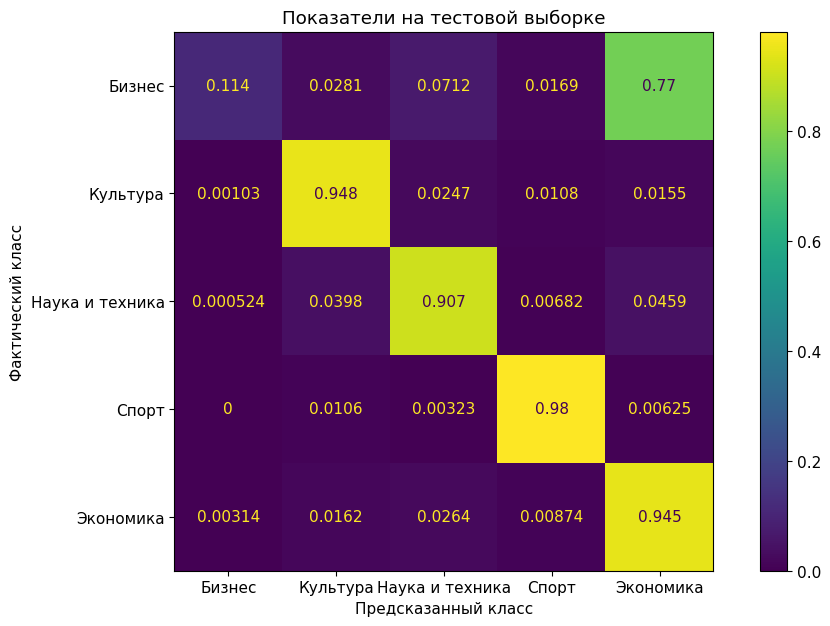

In [17]:
plot_confusion_matrix(
    nlp_pipeline,
    X_test,
    y_test,
    title="Показатели на тестовой выборке",
    font_size=11,
)

<h3>Лучший подход для решения этой задачи: токенизация из NLTK + удаление стоп-слов на русском и английском языке + удаление чисел + лемматизация + TF-IDF на униграммах, биграммах и триграммах + фильтрация через критерий хи-квадрат Пирсона. Выбор модели итоговой модели зависит от того что для нас критичнее в прогнозе по категории Бизнес: precision или recall. Если первое, то тогда нужно выбирать ComplementNB, если же recall, то Logistic Regression. Я выбрал ComplementNB для итогового pipeline, так как этот подход обладает следующими плюсами: скорость, точность, отсутствие переобучения.</h3>